In [1]:
%matplotlib inline
from matplotlib import rcParams, rcdefaults
from matplotlib.pyplot import subplots, style, hist, legend, plot, imshow, colorbar, title
from numpy import linspace
from scipy.optimize import curve_fit
rcParams['image.aspect'] = 'auto'
rcParams['figure.figsize'] = (10,8)
style.use('fivethirtyeight')

# Loading data

In [2]:
from iuvs import io

In [3]:
files = !ls ~/data/iuvs/level1b/*.gz
files

['/Users/maye/data/iuvs/level1b/mvn_iuv_l1b_cruisecal2-mode080-fuv_20140521T120028_v00_r00.fits.gz',
 '/Users/maye/data/iuvs/level1b/mvn_iuv_l1b_cruisecal2-mode080-muv_20140521T120028_v00_r00.fits.gz',
 '/Users/maye/data/iuvs/level1b/mvn_iuv_l1b_periapse-orbit00108-mode0001-fuv_20141018T113414_v01_r01.fits.gz',
 '/Users/maye/data/iuvs/level1b/mvn_iuv_l1b_periapse-orbit00108-mode0001-muv_20141018T113414_v01_r01.fits.gz']

In [4]:
l1b = io.L1BReader(files[1])

In [5]:
dark0 = l1b.detector_dark[0]
dark1 = l1b.detector_dark[1]
dark2 = l1b.detector_dark[2]

# Multiplicative comparison of darks

In [6]:
def myhist(data, **kwargs):
    hist(data.ravel(), 100, range=(0,5000), log=True, alpha=0.5, **kwargs)

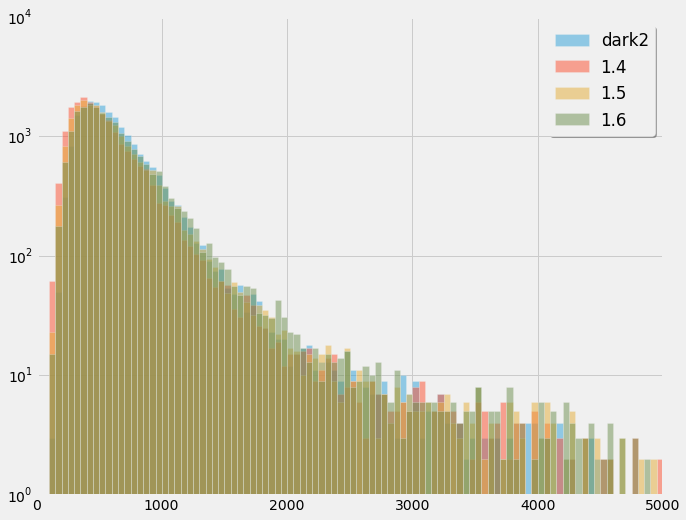

In [7]:
myhist(dark2, label='dark2')
for a in linspace(1.4,1.6, 3):
    myhist(dark1*a, label=str(a))
legend();

This looks promising, the shape of the histograms are getting very close with a simple multipication.

Below I compare how a spatially averaged spectral profile between the darks can be made look similar just with a multiplicative scaling.

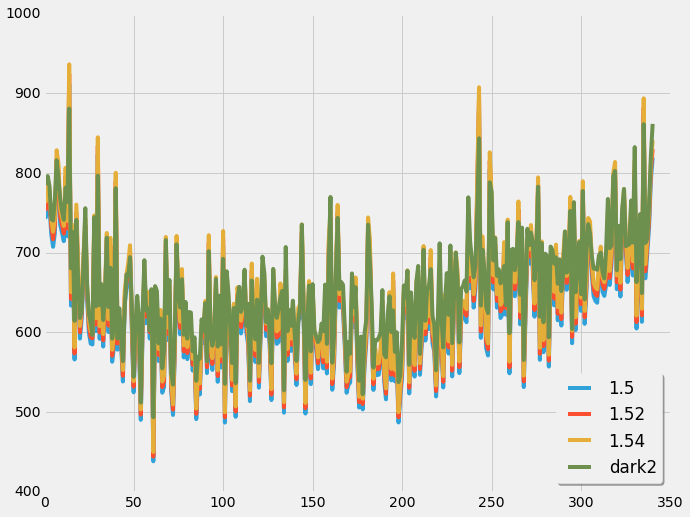

In [8]:
for a in [1.5,1.52, 1.54]:
    plot(a*dark1.mean(axis=0), label=str(a))
plot(dark2.mean(axis=0), label='dark2')
legend(loc='best');

#  Modeling the fit
In the old fashion way, one would define a model function and use a minimizer (here called `curve_fit` using least-square optimization) to find the parameters for which the model best approaches the data to recreate.

In our situation, the `model` is how to get from one dark to the other.

In [9]:
def multimodel(x, a):
    return a*x

In [10]:
def addmodel(x, a):
    return a+x

In [11]:
from scipy.optimize import curve_fit

Here I linearize all pixels for the darks to have simple 1D vectors of data to be matched with each other:

In [12]:
data_in = dark1.ravel()
data_out = dark2.ravel()

Now the fitting. `curve_fit` returns the coefficients as required by the model parameters above and the covariance matrix of the fit, with the errors for the coefficients given on the diagonal of that matrix.

In [13]:
mult_p0, mult_pcov = curve_fit(multimodel, data_in, data_out)
mult_perr = np.sqrt(np.diag(mult_pcov))

In [14]:
add_p0, add_pcov = curve_fit(addmodel, data_in, data_out)
add_perr = np.sqrt(np.diag(add_pcov))

I will now use a residual to define the quality of the fit, both as an absolute and as a ratio to the target data:

In [15]:
mult_residual = dark2 - multimodel(dark1, mult_p0)
add_residual = dark2 - addmodel(dark1, add_p0)

In [16]:
mult_fractional = (mult_residual/dark2)
add_fractional = (add_residual/dark2)

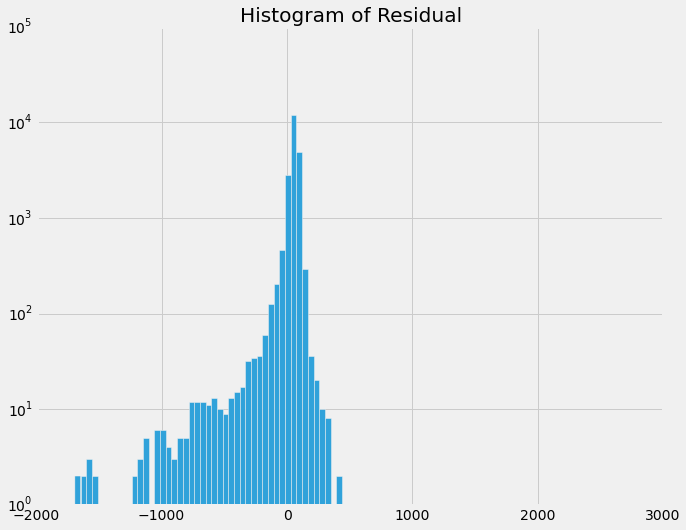

In [17]:
_, ax = subplots()
ax.hist(mult_residual.ravel(), 100, log=True);
ax.set_title('Histogram of Residual');

# Polynomial model
Using more advanced tools, I simply fit sets of polynomials with increasing degree `n` and apply this to the first dark vector.

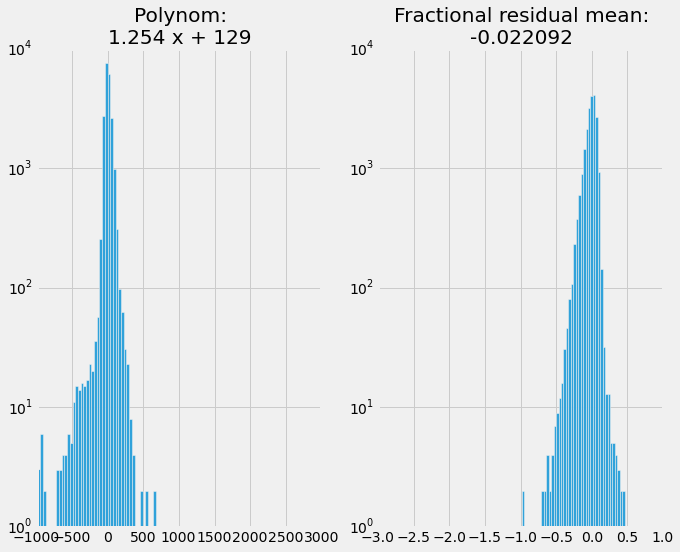

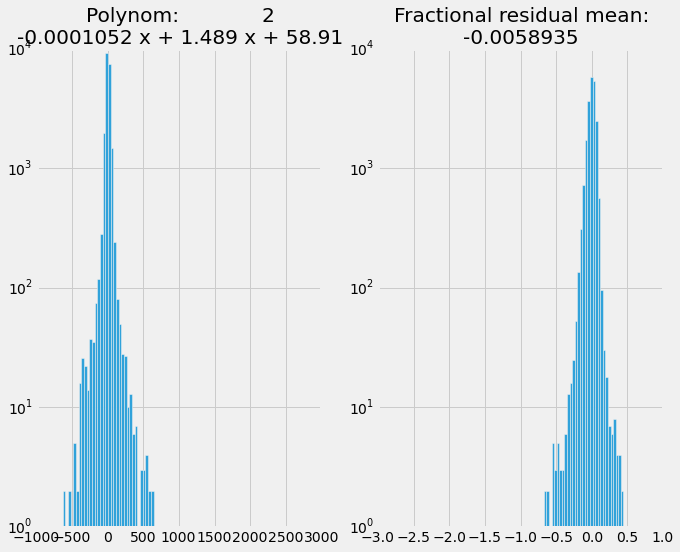

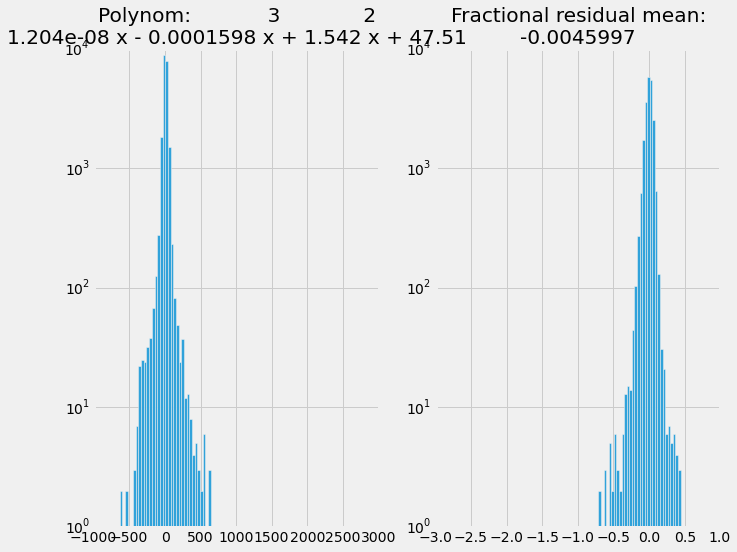

In [90]:
def do_polyfit(rank, dark_in, dark_out):
    z = np.polyfit(dark_in.ravel(), dark_out.ravel(), rank)
    poly = np.poly1d(z)
    residual = dark_out - poly(dark_in)
    fractional = residual/dark_out
    return poly, residual, fractional, poly(dark_in)

fitted_darks = []
residuals = []
for rank in range(1,4):
    poly, residual, fractional, fitted = do_polyfit(rank, dark1, dark2)
    residuals.append(residual)
    fitted_darks.append(fitted)
    fig, ax = subplots(ncols=2)
    ax[0].set_title("Polynom: {}".format(poly))
    ax[0].hist(residual.ravel(), 100, log=True)
    ax[1].hist(fractional.ravel(), 100, log=True)
#     ax[1].plot(fractional)
    ax[1].set_title("Fractional residual mean:\n{:.5}".format(fractional.mean()))

NameError: name 'add_fractional_mean' is not defined

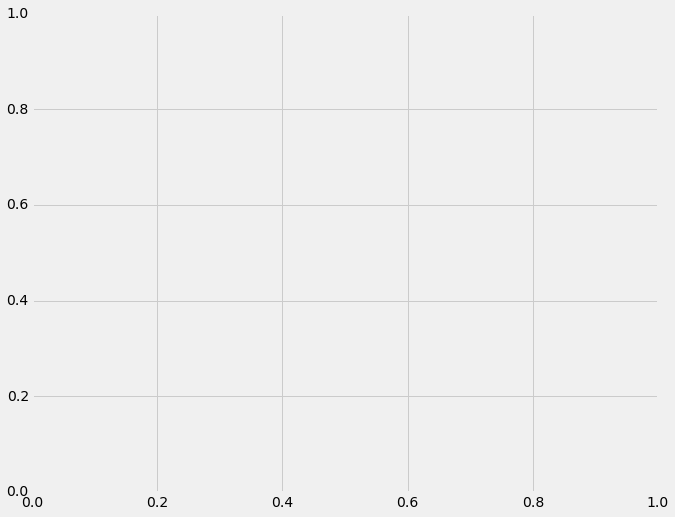

In [19]:
_, ax = subplots()
frac_residuals = []
for rank in range(1,10):
    poly, residual, fractional = do_polyfit(rank, data_in, data_out)
    frac_residuals.append(fractional.mean())
ax.plot([-1, 0] + list(range(1,10)), [add_fractional_mean, mult_fractional_mean]+frac_residuals,
       '*', ms=15)
ax.set_title("Fractional residual over degree $n$ of polynomial fit");

This plot shows at what degree of polynomial fit the fractional residual mean value reaches a plateau. I added the  fractional residual mean values for the pure additive model at -1 x-axis and the pure multiplicative at x-axis 0.

# Filtering out hot pixels

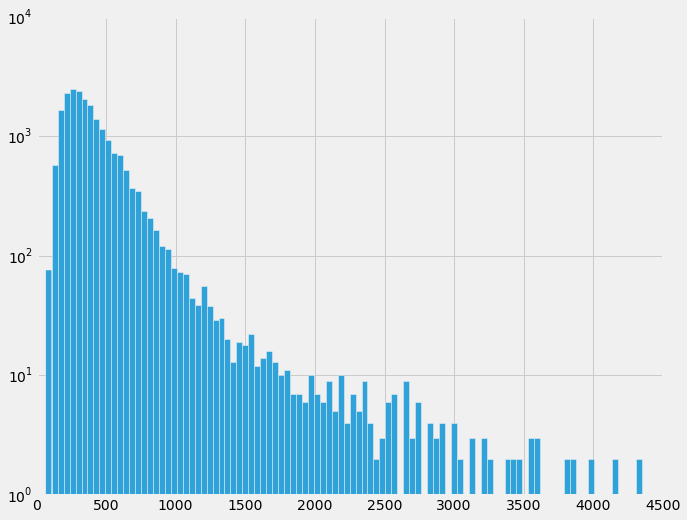

In [20]:
hist(data_in.ravel(), bins=100, log=True);

Using 2500 as a cut-off:

In [21]:
hot_d1_pixels = data_in > 2500

In [22]:
filtered_in = data_in[~hot_d1_pixels]

In [23]:
filtered_out = data_out[~hot_d1_pixels]

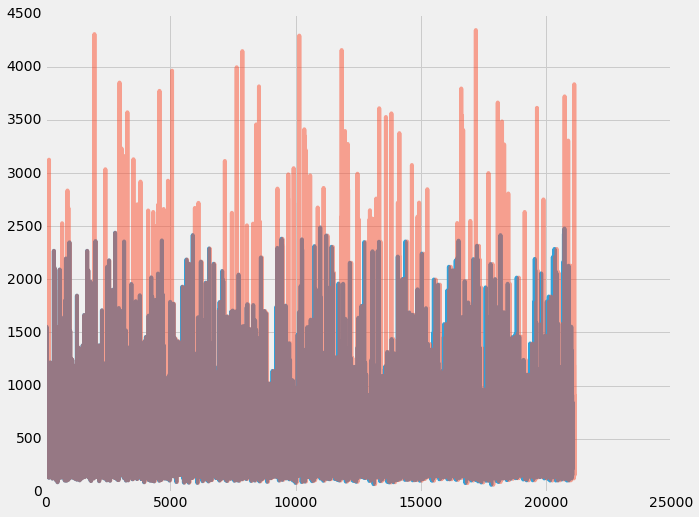

In [24]:
plot(filtered_in)
plot(data_in, alpha=0.5)

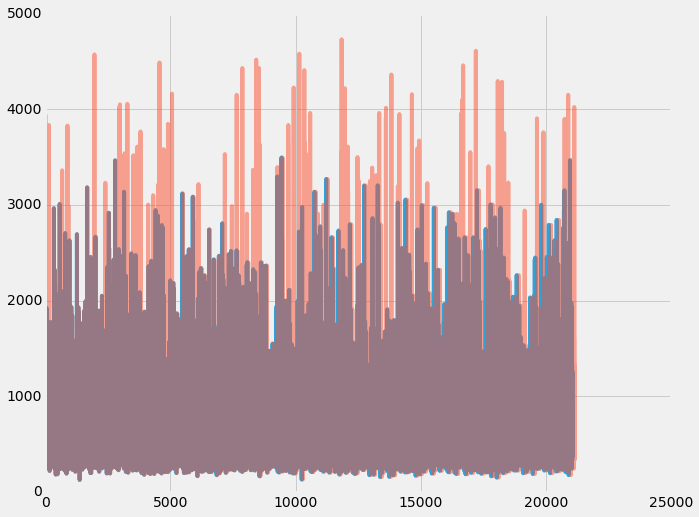

In [25]:
plot(filtered_out)
plot(data_out, alpha=0.5)

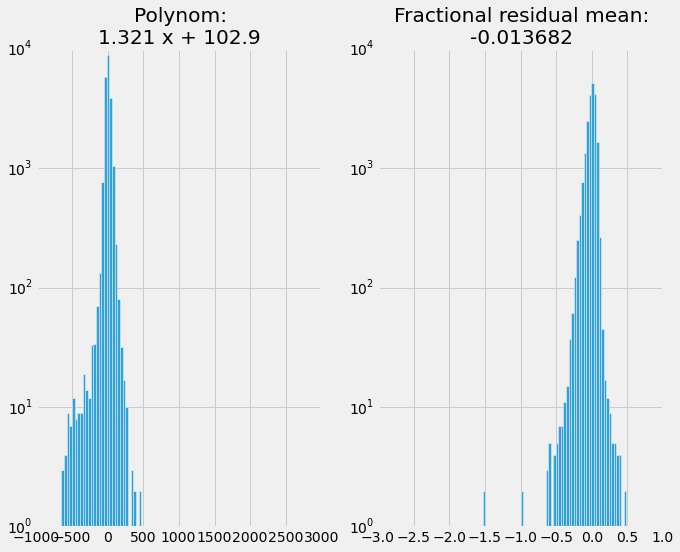

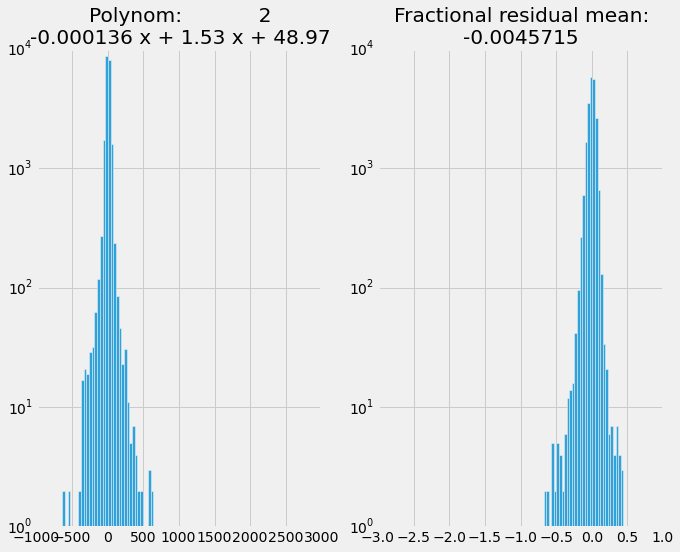

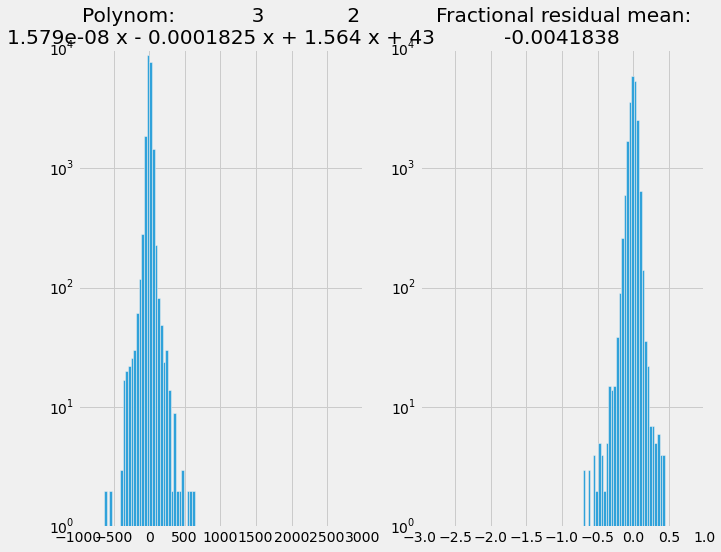

In [26]:
def do_polyfit(rank, data_in, data_out):
    z = np.polyfit(data_in, data_out, rank)
    poly = np.poly1d(z)
    residual = data_out - poly(data_in)
    fractional = residual/data_out
    return poly, residual, fractional

for rank in range(1,4):
    poly, residual, fractional = do_polyfit(rank, filtered_in, filtered_out)
    fig, ax = subplots(ncols=2)
    ax[0].set_title("Polynom: {}".format(poly))
    ax[0].hist(residual.ravel(), 100, log=True)
    ax[1].hist(fractional, 100, log=True)
    ax[1].set_title("Fractional residual mean:\n{:.5}".format(fractional.mean()))

This does not seem to remove the left side asymmetry of the residual histogram.

In [27]:
dark_in = dark1.ravel()
dark_out = dark2.ravel()
coeffs = np.polyfit(dark_in, dark_out, 2)
fitpoly = np.poly1d(coeffs)
dark1_scaled = fitpoly(dark1)


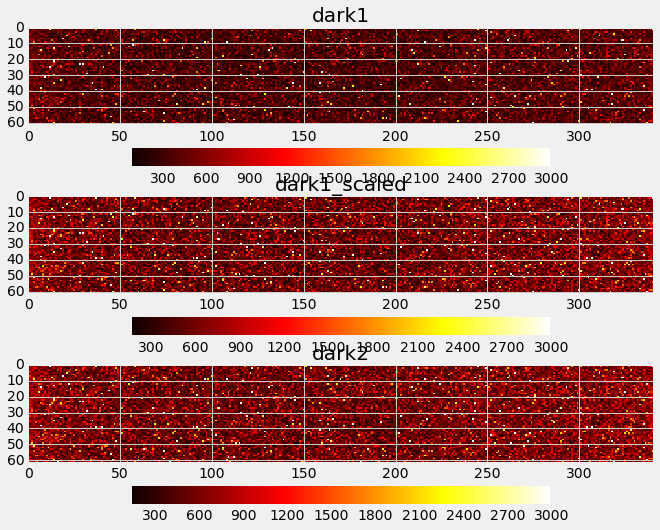

In [28]:
fig, axes = subplots(nrows=3)
for dark,ax,label in zip([dark1, dark1_scaled, dark2], axes, 
                         'dark1 dark1_scaled dark2'.split()):
    im = ax.imshow(dark, cmap='hot', vmax=3000)
    colorbar(im, ax=ax, orientation='horizontal')
    ax.set_title(label)

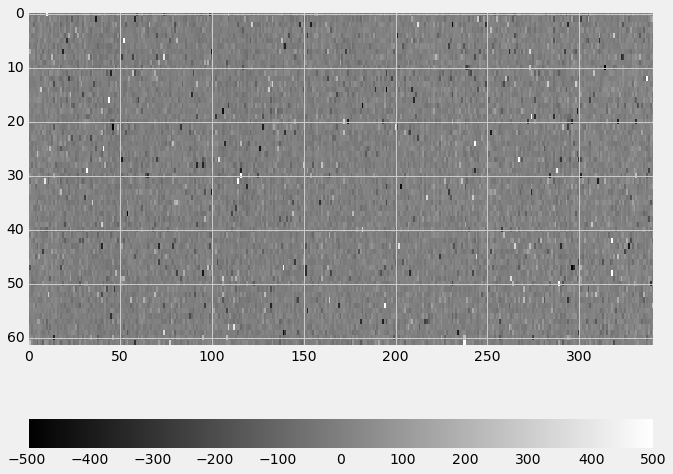

In [29]:
imshow(dark2 - dark1_scaled, cmap='gray', vmin=-500, vmax=500)
colorbar(orientation='horizontal')

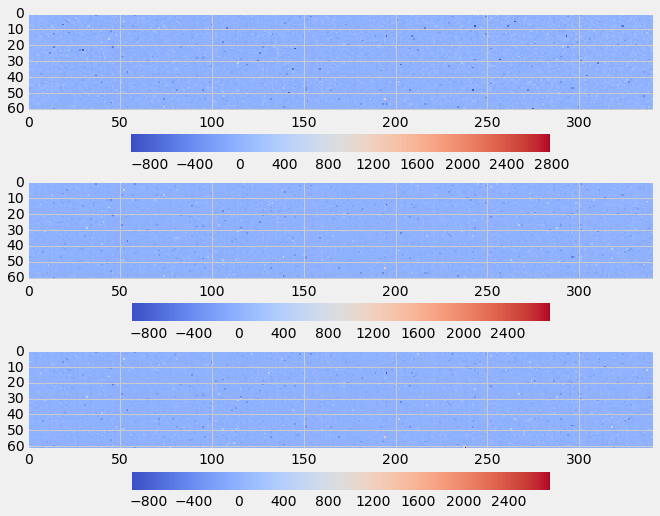

In [35]:
fig, axes = subplots(nrows=3)
for ax, fitted in zip(axes[:3], fitted_darks):
    im = ax.imshow(fitted)
    colorbar(im, ax=ax, orientation='horizontal')

# scatter plot

In [84]:
from matplotlib.pyplot import scatter

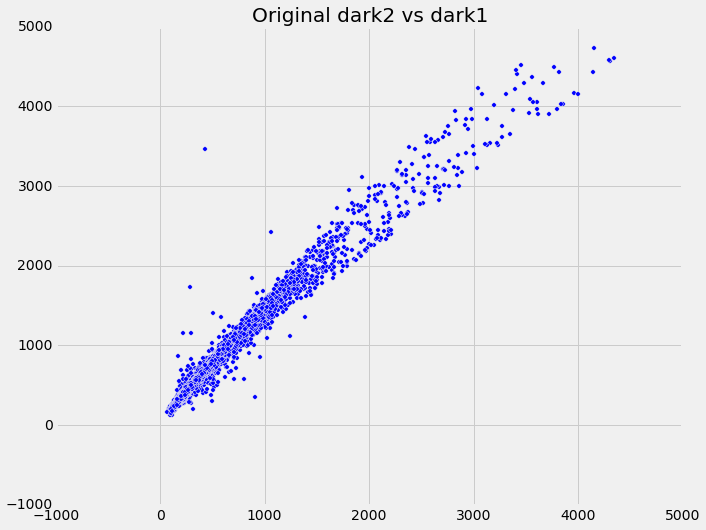

In [96]:
scatter(dark1, dark2)
title('Original dark2 vs dark1')

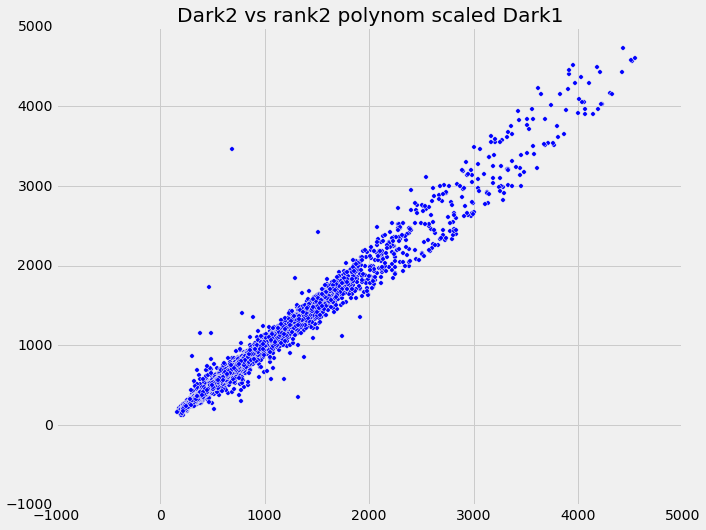

In [97]:
scatter(fitted_darks[1], dark2)
title('Dark2 vs rank2 polynom scaled Dark1')

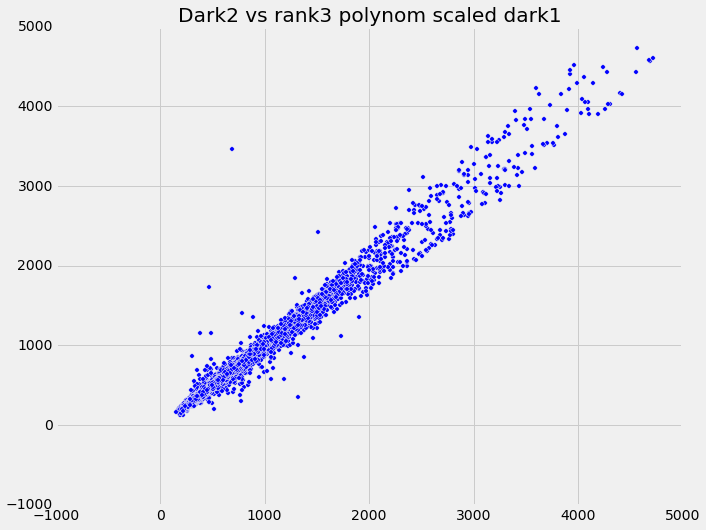

In [98]:
scatter(fitted_darks[-1], dark2)
title('Dark2 vs rank3 polynom scaled dark1')

In [82]:
d1 = dark1
d2 = dark2
from iuvs.scaling import AddScaler, MultScaler, PolyScaler
for scaler in [AddScaler(d1, d2), MultScaler(d1,d2),
               PolyScaler(d1, d2, 1), PolyScaler(d1,d2, 2),
               PolyScaler(d1, d2, 3), PolyScaler(d1,d2, 4)]:
    scaler.do_fit()
    print(scaler.p)

[ 235.82480371]
[ 1.45105018]
[   1.25358629  129.03443681]
[ -1.05188655e-04   1.48883277e+00   5.89136460e+01]
[  1.20359877e-08  -1.59788895e-04   1.54201743e+00   4.75131716e+01]
[ -7.63104617e-12   6.48484297e-08  -2.67445054e-04   1.61040433e+00
   3.60141673e+01]


In [93]:
from iuvs.scaling import PolyScalerManager

In [94]:
polymanager = PolyScalerManager(dark1, dark2, 1, 10)

In [65]:
darkwriter = io.DarkWriter('test_darkwriter.fits', dark1, dark2,clobber=True)